# LSTM model - text embedding + price hist

In [1]:
# import packages

import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow import keras

import datetime
import matplotlib.pyplot as plt
import preprocessor as p

from utils.embed_utils import read_glove_vecs

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import re
import string

In [2]:
# load data

def load_data(train_or_test):
    if train_or_test not in ['train', 'test']:
        return None
    path = 'data\CombinedTWTAQ_' + train_or_test + '.pkl'
    with open(path, 'rb') as infile:
        df = pickle.load(infile)
    return df

def clean_text(text):
    '''
    lowercase, remove puncs, remove urls
    '''
    text = p.clean(text)
    text = text.lower()
    #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r"http\S+", ' ', text)
    return text
    
clean = lambda x: clean_text(x)

def df_to_xy(df):
    x_text = df.text.apply(clean).values
    x_price = df.PP.apply(lambda xx: xx[:60]).values
    y = df.PP.apply(lambda xx: xx[75]).values
    #y = y.values
    return ([x_text,x_price],y)

def sentences_to_indices_V2(X, word_to_index, max_len, padding='pre'):
    
    m = X.shape[0]
    X_ind = [[word_to_index[w] for w in text.lower().split() if w in word_to_index.keys()] for text in X]
    X_ind = keras.preprocessing.sequence.pad_sequences(X_ind, maxlen=max_len, padding=padding)
    return X_ind

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        if word_to_vec_map[word].shape[0] == emb_dim:
            emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it non-trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = keras.layers.Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [3]:
x,y = df_to_xy(load_data('test'))
print(type(x[0]), type(x[1]))
print(type(y))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Load embedding

In [4]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('utils/glove.twitter.27B.50d.txt')

In [5]:
word = "v"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

text = 'I am Donald J. Trump.'
max_len = 10

print(sentences_to_indices_V2(np.array([text]), word_to_index, max_len, padding='pre'))

the index of v in the vocabulary is 633196
the 289846th word in the vocabulary is jajajajajaajaja
[[266801  22927 163843 288537  26338 266801  22927  25726 266801 319575]]


## Load data

In [7]:
def combine_text_price_data(texts,price_hist,word_to_index,max_len=140, EMB_DIM=50):
    texts_ind = sentences_to_indices_V2(texts, word_to_index, max_len, padding='pre')
    price_hist = np.stack(price_hist)
    price_hist = price_hist.reshape(price_hist.shape[0], price_hist.shape[1],1)
    X = [texts_ind, price_hist]
    return X

In [7]:
max_len = 140
EMB_DIM = 50

df_train = load_data('train')
x, y = df_to_xy(df_train)
texts = x[0]
price_history = x[1]

texts_train, texts_dev, price_hist_train, price_hist_dev, y_train, y_dev = train_test_split(texts,price_history,y, test_size=200, random_state=50)

m_train = texts_train.shape[0]
m_dev = texts_dev.shape[0]

X_train = combine_text_price_data(texts_train, price_hist_train, word_to_index,max_len,EMB_DIM)
X_dev = combine_text_price_data(texts_dev, price_hist_dev, word_to_index,max_len,EMB_DIM)


## Model

In [16]:
def create_LSTM_model(text_input_shape, price_input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = keras.layers.Input(shape=text_input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   

    X1 = keras.layers.LSTM(4, return_sequences=True, name='LSTM11')(embeddings)
    X1 = keras.layers.Dropout(0.25,name='Dropout11')(X1)
    X1 = keras.layers.LSTM(4, return_sequences=False, name='LSTM12')(X1)
    X1 = keras.layers.Dropout(0.25,name='Dropout12')(X1)
    
    price_hist = keras.layers.Input(shape=price_input_shape, dtype='float32')
    
    X2 = keras.layers.LSTM(4, return_sequences=True, name='LSTM21')(price_hist)
    X2 = keras.layers.Dropout(0.1,name='Dropout21')(X2)
    X2 = keras.layers.LSTM(4, return_sequences=False, name='LSTM22')(X2)
    X2 = keras.layers.Dropout(0.1,name='Dropout22')(X2)
    
    X = keras.layers.concatenate([X1,X2])
    X = keras.layers.Dense(4 ,name='Dense',activation='relu')(X)
    X = keras.layers.Dropout(0.2,name='Dropout3')(X)
    X = keras.layers.Dense(1,activation='linear')(X)
    
    
    # Create Model instance which converts sentence_indices into X.
    model = keras.models.Model(inputs=[sentence_indices, price_hist], outputs=X)
    
    return model


text_input_shape = (max_len,)
price_input_shape = (60,1,)

tf.reset_default_graph()

model = create_LSTM_model(text_input_shape, price_input_shape, word_to_vec_map, word_to_index)

model.summary()

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

model.fit(X_train, y_train, epochs=100)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 50)      59675750    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
LSTM11 (LSTM)                   (None, 140, 4)       880         embedding[0][0]                  
______________________________________________________________________________________________

## Evaluate accuracy

In [17]:
#x_train = [texts_train, price_hist_train]
#x_dev = [texts_dev, price_hist_dev]


print( np.sqrt( mean_squared_error(y_train, model.predict(X_train)) ) )
print( np.sqrt( mean_squared_error(y_dev, model.predict(X_dev)) ) )

0.13908659882018262
0.14892361778328395


## Conclusion


Guess 0:
- Train SE: 15.13
- Dev SE: 15.25

Linear regression model with regularization (alpha=200):
- Train SE: 13.86
- Dev SE: 15.19

Linear regression model using GloVe embedding with reg (alpha=400):
- Train SE: 15.01
- Dev SE: 15.24

NN model with embedding (glove.6B.50d):
- Train SE: 14.43
- Dev SE: 15.47

NN model with twitter embedding (glove.twitter.27B.50d.txt):
- Train SE: 14.40
- Dev SE: 15.47

LSTM model with twitter embedding:
- Train SE: 15.06
- Dev SE: 15.20

Hybrid LSTM twitter embedding for text and price history:
- Train SE: 14.46 (original) 13.91 (long train+extra dropout)
- Dev SE: 15.11, 14.89

In [18]:
# save model
savepath = 'Model_08_twitter_embed_price_hist_LSTM_long_train_100.h5'
model.save(savepath)

In [5]:
#from keras.models import load_model
load_path = 'Model_08_twitter_embed_price_hist_LSTM_long_train_100.h5'
model_load = keras.models.load_model(load_path)
model_load.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140)]        0                                            
_________________________________________

## Test

Final run

In [9]:
df_test = load_data('test')

x_test, y_test = df_to_xy(df_test)

max_len = 140
EMB_DIM = 50

df_train = load_data('test')
x, y = df_to_xy(df_train)
texts_test = x[0]
price_hist_test = x[1]

m_test = texts_test.shape[0]

X_test = combine_text_price_data(texts_test, price_hist_test, word_to_index,max_len,EMB_DIM)

y_test_hat =  model_load.predict(X_test)

print( np.sqrt( mean_squared_error(y_test, y_test_hat) ) )

0.1538709231060276


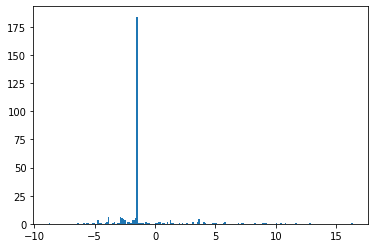

In [10]:
plt.figure()
plt.hist(100*y_test_hat,201)
plt.show()

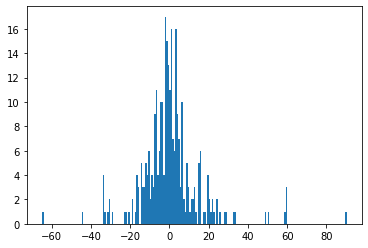

In [11]:
plt.figure()
plt.hist(100*y_test,201)
plt.show()